In [2]:
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

from scipy.stats import pearsonr as lincorr

from functools import partial

import sys
sys.path.append('/gpfs01/euler/User/lhoefling/GitHub/nnfabrik_euler')

In [4]:
from rgc_natstim_model.utils.inference import get_model_responses
from rgc_natstim_model.utils.data_handling import convert_nested_dict_to_dataframe

In [5]:
from rgc_natstim_model.analyses.eval import calculate_correlations, calculate_nat_reliability_index

# Import constants

In [6]:
from rgc_natstim_model.constants.identifiers import dh2eh, dh2eh_linear, example_nids

# Load data from file

In [7]:
data_path = '/gpfs01/euler/User/lhoefling/project_clean_up/data/mei_analysis/'

In [8]:
!ls /gpfs01/euler/User/lhoefling/Data/dataframes/20220821_10_54_26/

cleaned_df_f7c1eadf7531672f02344053adf96439_.pkl
example_types_df_f7c1eadf7531672f02344053adf96439_.pkl
full_df_2c79eba0cbf62206ff50e73b2dc21e03_.pkl


In [9]:
with open(os.path.join(data_path, 'cleaned_df_f7c1eadf7531672f02344053adf96439_.pkl'), 'rb') as f:
    full_df = pickle.load(f)

In [11]:
full_df['method_hash']

neuron_id
20210929_1_1_101_s_5    d9d8fe9725fb8667fa71c7ab44889c37
20210930_1_1_93_s_5     d9d8fe9725fb8667fa71c7ab44889c37
20210930_2_1_18_s_5     d9d8fe9725fb8667fa71c7ab44889c37
20210930_2_1_44_s_5     d9d8fe9725fb8667fa71c7ab44889c37
20210930_2_1_107_s_5    d9d8fe9725fb8667fa71c7ab44889c37
                                      ...               
20200707_2_4_36_s_5     d9d8fe9725fb8667fa71c7ab44889c37
20200707_2_4_123_s_5    d9d8fe9725fb8667fa71c7ab44889c37
20200707_2_4_150_s_5    d9d8fe9725fb8667fa71c7ab44889c37
20200707_2_4_153_s_5    d9d8fe9725fb8667fa71c7ab44889c37
20201022_2_2_87_s_5     d9d8fe9725fb8667fa71c7ab44889c37
Name: method_hash, Length: 1613, dtype: object

In [8]:
with open(os.path.join(data_path, 'mei_analysis_df.pkl'), 'rb') as f:
    print(f)
    cleaned_df = pickle.load(f)

<_io.BufferedReader name='/gpfs01/euler/User/lhoefling/project_clean_up/data/mei_analysis/cleaned_df_f7c1eadf7531672f02344053adf96439_.pkl'>


In [9]:
[print(c) for c in cleaned_df.columns]

log_off_diag_ratio_temp_cont
proj_offdiag_temp_cont
proj_diag_temp_cont
log_off_diag_ratio_freq
proj_offdiag_freq
proj_diag_freq
log_off_diag_ratio_size
proj_offdiag_size
proj_diag_size
center_temp_cont_uv
center_temp_cont_green
singular_values
recon_mei
mei
abs_max
valid_surround_uv
valid_surround_green
test_corr
roiy_corrected
roix_corrected
neuron_id
experimenter
date
exp_num
field_id
max_conf
roi_id
eye
projname
setupid
prep
preprem
darkadapt_hrs
slicethickness_um
bathtemp_degc
prepwmorient
odx
ody
odz
od_valid_flag
fromfile
roi_mask
absx
absy
absz
relx
rely
relz
roi_size
roix
roiy
roiz
session_id
date_str
training_data_hash
classifier_params_hash
classifier_seed
detrend_param_set_id
cell_filter_params_hash
celltype
confidence
preproc_chirp
preproc_bar
stim_id
presentation_id
movie_qi
movie_min_qi
movie_snippets
movie_qi_raw
movie_min_qi_raw
movie_snippets_raw
dataset_fn
dataset_hash
neuron_position
n_rois
mu_y_surround_uv
mu_x_surround_uv
mu_y_center_uv
mu_x_center_uv
normalized_s

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# plot settings

In [12]:
rc_dict = {'figure.dpi': 300,
                     'figure.figsize': [2,2],
                     'figure.frameon': False,
                     'font.size': 8,
                     'lines.markersize':3,
           'lines.markeredgewidth': .5,
                     'legend.columnspacing': .5,
                     'legend.frameon': False,
                     'legend.markerscale': .4,
                     'legend.labelspacing': 0.1,
                     'legend.handletextpad': 0,
                     'legend.loc': "lower right",
           'axes.labelpad': 1.0,
            'xtick.major.pad': 1, 'ytick.major.pad': 1,
                
                     }

In [13]:
rc_dict_hist = {'figure.dpi': 300,
                     'figure.figsize': [2,1],
                     'figure.frameon': False,
                     'font.size': 8,
                     'lines.markersize':5,
                     'legend.columnspacing': .5,
                     'legend.frameon': False,
                     'legend.markerscale': .7,
                     'legend.labelspacing': 0.1,
                     'legend.handletextpad': 0,
                     'legend.loc': "lower right",
                'axes.labelpad': 1.0,
                'xtick.major.pad': 1, 'ytick.major.pad': 1,
                     }

In [14]:
markers = ['o', 'd', 's']

# import plotting functions

In [39]:
#from mei.plot_utils.mei_plots import space_time_plot_from_df, spatial_plot_from_df, spatial_temporal_chromatic_plot_from_df
from rgc_natstim_model.plotting.mei_properties import spatial_temporal_chromatic_plot_from_df, space_time_plot_from_df

In [16]:
from rgc_natstim_model.constants.plot_settings import cmap_colors

In [17]:
from matplotlib.ticker import MaxNLocator, FixedLocator

# import MEI analysis functions

In [18]:
from rgc_natstim_model.analyses.mei_properties import calculate_angle

## calculate additional MEI properties

Size

In [19]:
calculate_angle(cleaned_df, 
                target_column='angle_size',
                diag_column='proj_diag_size',
                offdiag_column='proj_offdiag_size'
               )

In [20]:
thr_angle_rad_size = np.nanpercentile(cleaned_df["angle_size"], 95)
x = np.cos(thr_angle_rad_size+.25*np.pi)*500
y = np.sin(thr_angle_rad_size+.25*np.pi)*500

Frequency

In [21]:
calculate_angle(cleaned_df, 
                target_column='angle_freq',
                diag_column='proj_diag_freq',
                offdiag_column='proj_offdiag_freq'
               )

In [22]:
thr_angle_rad_freq = np.nanpercentile(cleaned_df["angle_freq"], 95)
x = np.cos(thr_angle_rad_freq+.25*np.pi)*4.5
y = np.sin(thr_angle_rad_freq+.25*np.pi)*4.5

In [23]:
calculate_angle(cleaned_df, 
                target_column='angle_temporal_contrast',
                diag_column='proj_diag_temp_cont',
                offdiag_column='proj_offdiag_temp_cont'
               )

In [24]:
thr_angle_rad = np.nanpercentile(cleaned_df["angle_temporal_contrast"], 95)

# example cell plots

In [25]:
sample_ids = ["20210910_2_4_77_s_5",
                "20201117_2_2_15_s_5",
                '20201030_1_1_16_s_5',]

for neuron_id in sample_ids:
    spatial_plot_from_df(cleaned_df, neuron_id);

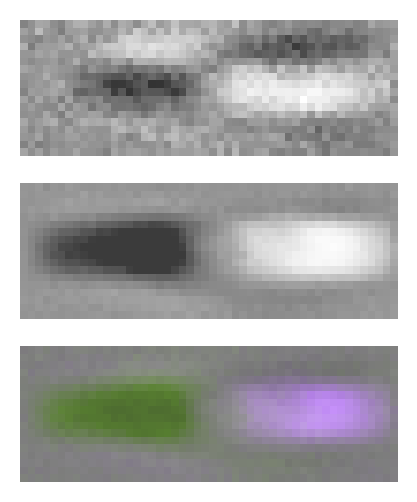

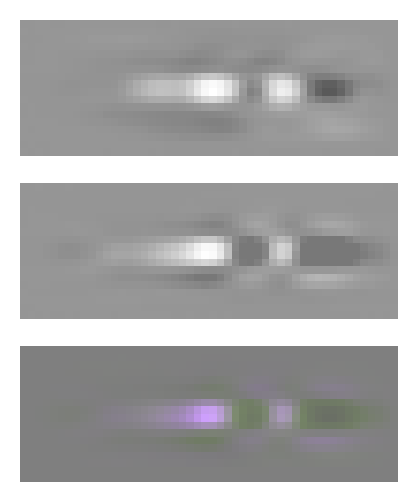

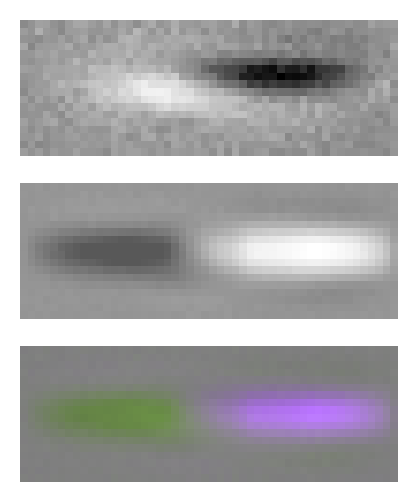

In [40]:
for neuron_id in sample_ids:
    space_time_plot_from_df(cleaned_df, neuron_id, normalize='separately');

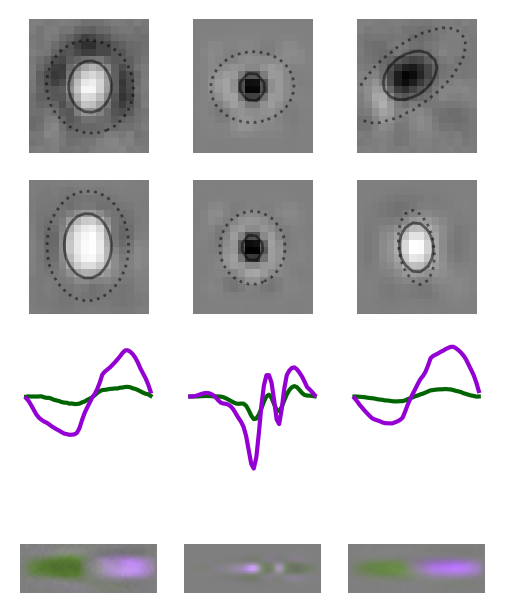

In [38]:
spatial_temporal_chromatic_plot_from_df(cleaned_df, sample_ids);

# Population level plots

In [31]:
valid_types = np.unique(cleaned_df["celltype"])

### MEI size

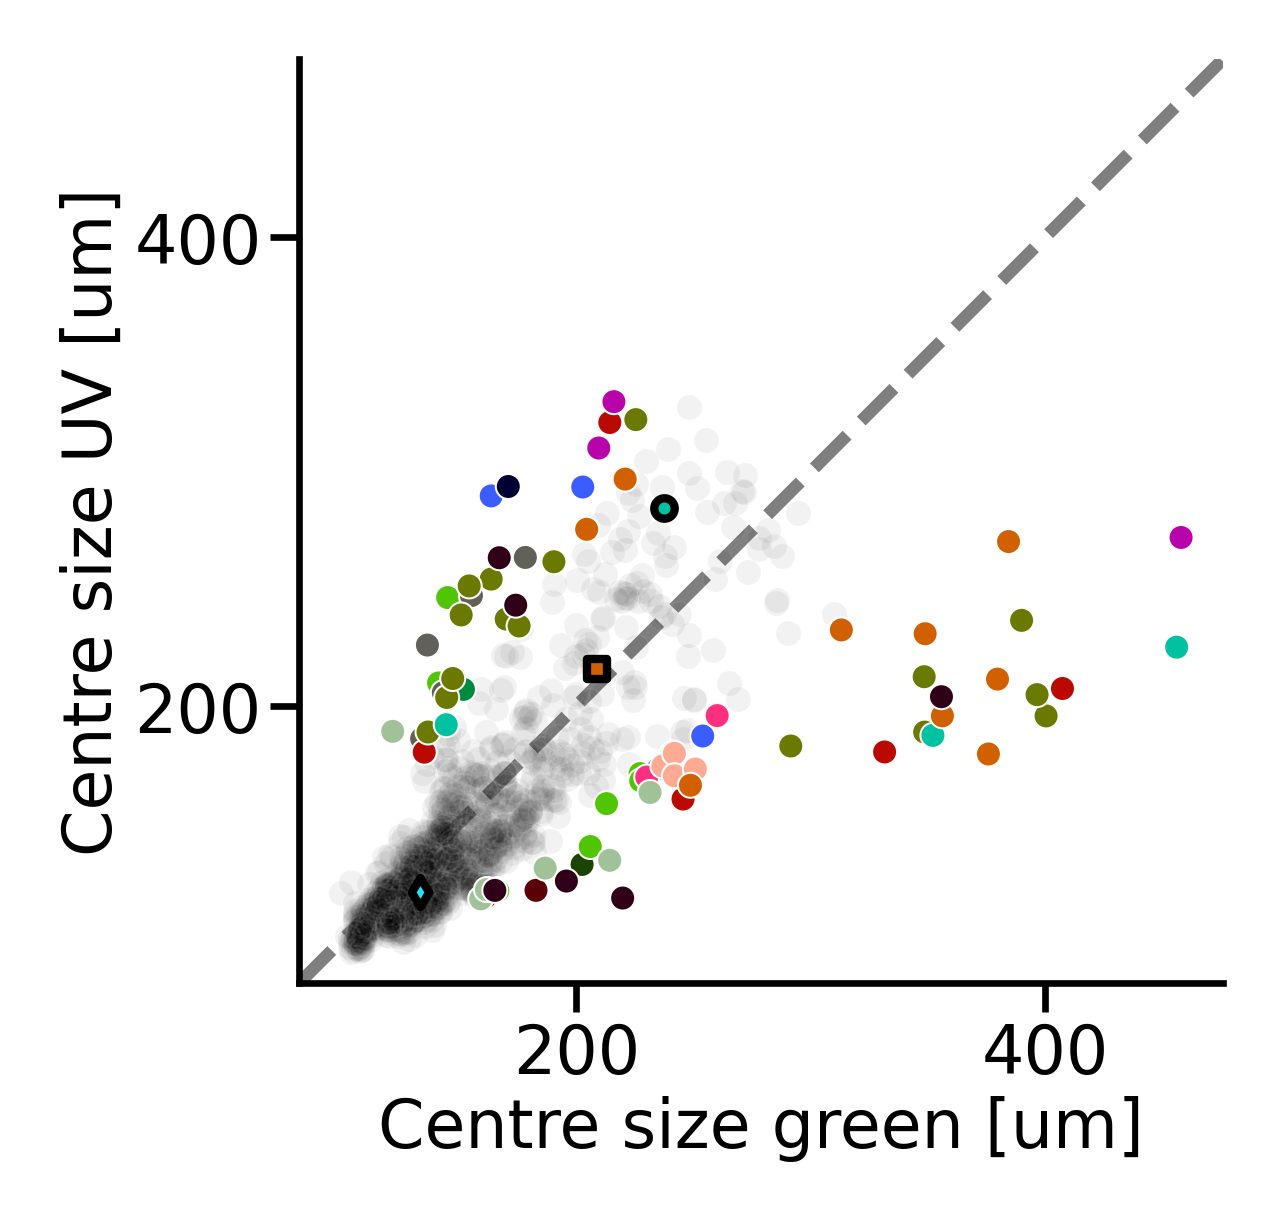

In [32]:
with mpl.rc_context(rc_dict):
    fig = plt.figure()
    xlabel="Centre size green [um]"
    ylabel="Centre size UV [um]"
    xkey = "center_size_um_green"
    ykey = "center_size_um_uv"
    g = sns.scatterplot(data=cleaned_df, 
                    x="center_size_um_green", 
                    y="center_size_um_uv",
                    color="k",
                        alpha=.05
                    )
    for sample_id, m in zip(sample_ids, markers):
        plt.scatter(cleaned_df.loc[sample_id][xkey],
                         cleaned_df.loc[sample_id][ykey],
                   color = cmap_colors[cleaned_df["celltype"].loc[sample_id]-1], s=6, marker=m,
                                       edgecolors='k', 

                   )

    temp_types = np.unique(cleaned_df[cleaned_df["angle_size"]>thr_angle_rad_size]["celltype"])
    temp_palette = [cmap_colors[t-1] for t in temp_types]
    temp_df = cleaned_df[cleaned_df["angle_size"]>thr_angle_rad_size]
    sns.scatterplot(data=temp_df, 
                    x="center_size_um_green", 
                    y="center_size_um_uv",
                    ax=g,
                    hue="celltype", palette=temp_palette, 
                    legend=False,
                    zorder=200,
                    
                    )

    
    g.set_aspect("equal")
    xlim = g.get_xlim()
    ylim  = g.get_ylim()
    lims = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]

    g.set_xlim(lims)
    g.set_ylim(lims)
    g.xaxis.set_major_locator(MaxNLocator(2))
    g.yaxis.set_major_locator(MaxNLocator(2))
    
    g.plot(lims, lims, color="k", linestyle="dashed",
           alpha=.5, zorder=0)
    
    g.plot([0, x], [0, y], color="k", linewidth=1, alpha=.5, zorder=1)
    g.plot([0, y], [0, x], color="k", linewidth=1, alpha=.5, zorder=1)
    g.set_xlabel(xlabel)
    g.set_ylabel(ylabel)
    #g.axis("off")
    sns.despine()

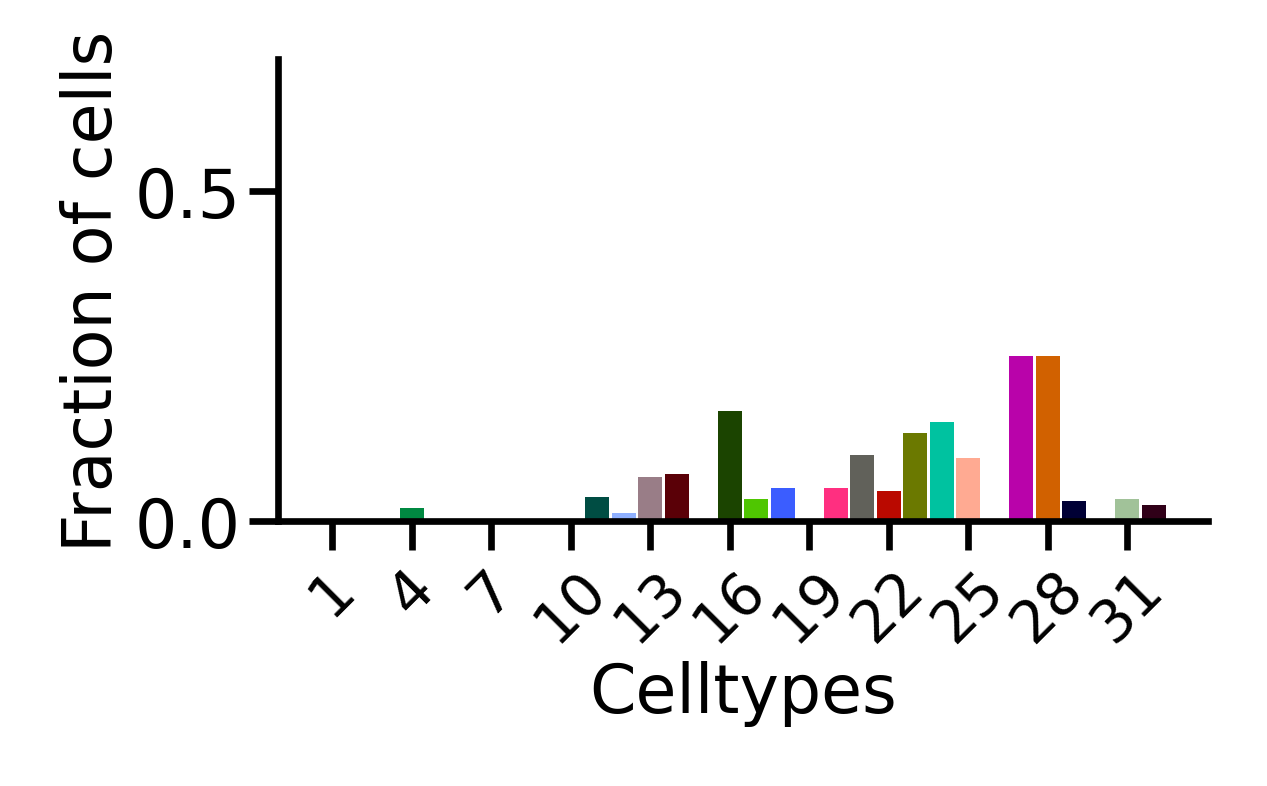

In [33]:
with mpl.rc_context(rc_dict_hist):
    fig = plt.figure()
    ax = plt.gca()
    for t in valid_types:
        perc = len(cleaned_df[(cleaned_df["celltype"]==t) & (cleaned_df["angle_size"]>thr_angle_rad_size)])/len(cleaned_df[cleaned_df["celltype"]==t])
        #print(t, perc)
        ax.bar(t, height=perc, width = .9,
               color=cmap_colors[t-1])
    sns.despine()
    ticklabels = [i for i in range(1, 32, 3)]
    ax.xaxis.set_major_locator(FixedLocator(ticklabels))
    ax.set_xticklabels(ticklabels, rotation=45, fontsize=7)
    #ax.set_xticks([])
    ax.set_xlabel("Celltypes")
    ax.set_ylabel("Fraction of cells")
    ax.set_ylim(0, 0.7)

### Frequency

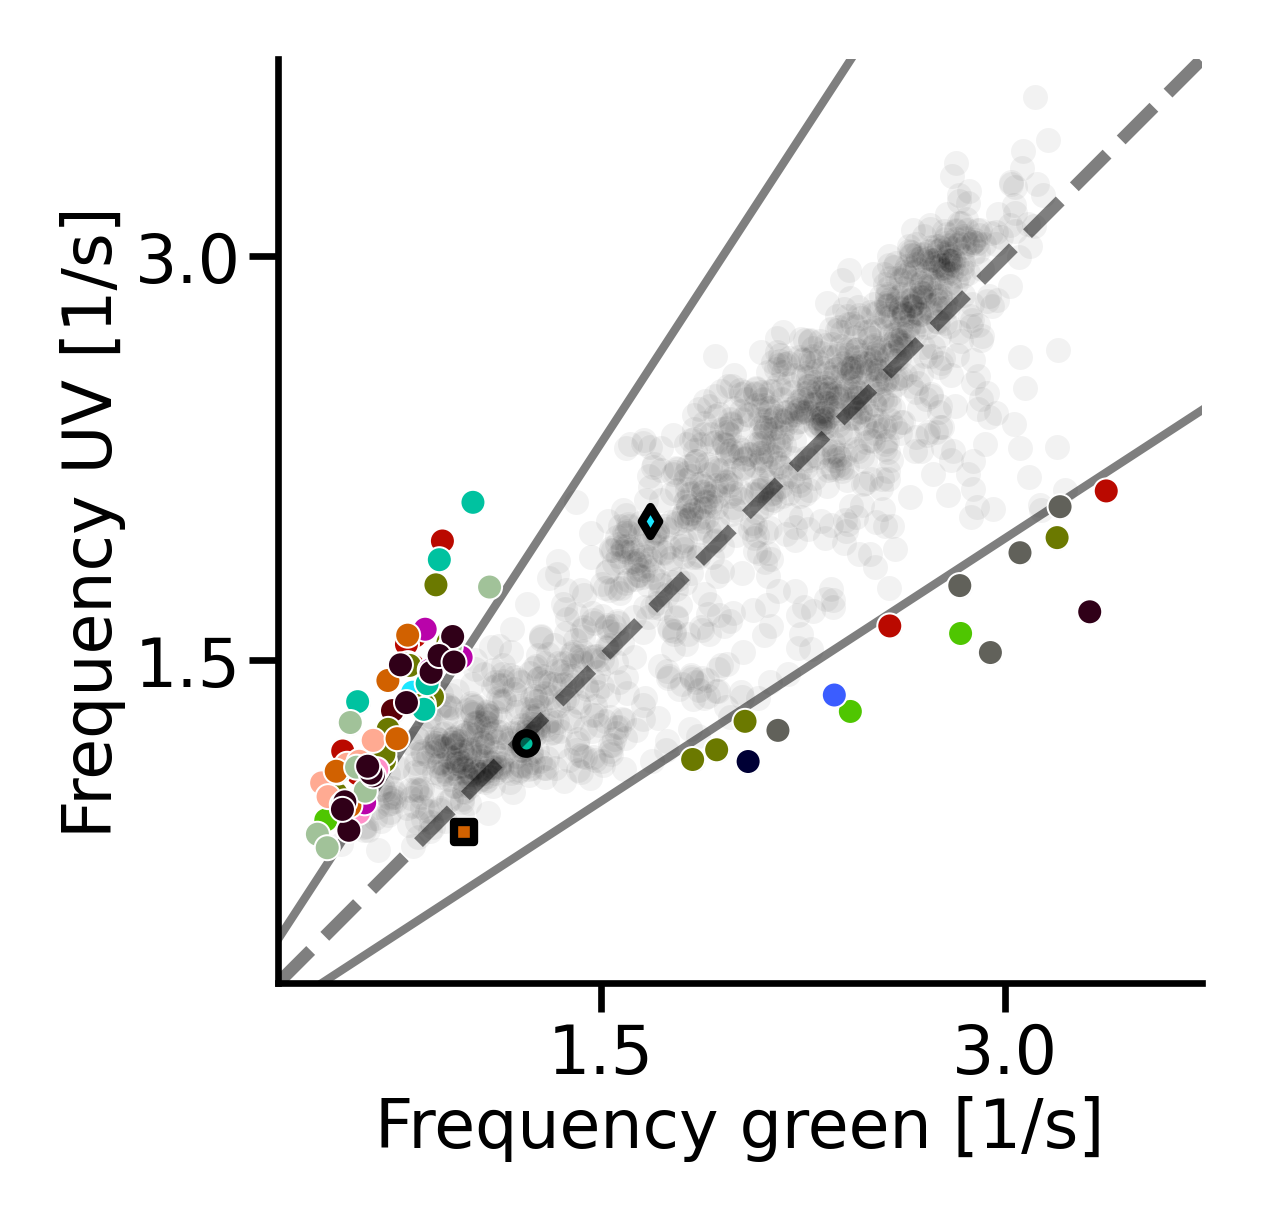

In [34]:
with mpl.rc_context(rc_dict):
    fig = plt.figure()
    xlabel="Frequency green [1/s]"
    ylabel="Frequency UV [1/s]"
    xkey="freq_green"
    ykey="freq_uv"
    g = sns.scatterplot(data=cleaned_df, 
                    x="freq_green", 
                    y="freq_uv",
                    color="k",
                        alpha=.05
                        #hue="celltype", palette=palette, legend=False
                    )
    temp_types = np.unique(cleaned_df[cleaned_df["angle_freq"]>thr_angle_rad_freq]["celltype"])
    temp_palette = [cmap_colors[t-1] for t in temp_types]
    temp_df = cleaned_df[cleaned_df["angle_freq"]>thr_angle_rad_freq]
    sns.scatterplot(data=temp_df, 
                    x=xkey, 
                    y=ykey,
                    ax=g,
                    hue="celltype", palette=temp_palette, 
                    legend=False,
                    zorder=200,
                    
                    )
    for sample_id, m in zip(sample_ids, markers):
        plt.scatter(cleaned_df.loc[sample_id][xkey],
                     cleaned_df.loc[sample_id][ykey],
                   color = cmap_colors[cleaned_df["celltype"].loc[sample_id]-1], s=6, marker=m,
                    edgecolors='k'
                   )
    g.set_aspect("equal")
    xlim = g.get_xlim()
    ylim  = g.get_ylim()
    lims = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
    g.set_xlim(lims)
    g.set_ylim(lims)
    g.xaxis.set_major_locator(MaxNLocator(3))
    g.yaxis.set_major_locator(MaxNLocator(3))
    
    g.plot(lims, lims, color="k", linestyle="dashed",
           alpha=.5)

    g.set_xlabel(xlabel)
    g.set_ylabel(ylabel)
    g.plot([0, x], [0, y], color="k", linewidth=1, alpha=.5, zorder=1)
    g.plot([0, y], [0, x], color="k", linewidth=1, alpha=.5, zorder=1)
    sns.despine()


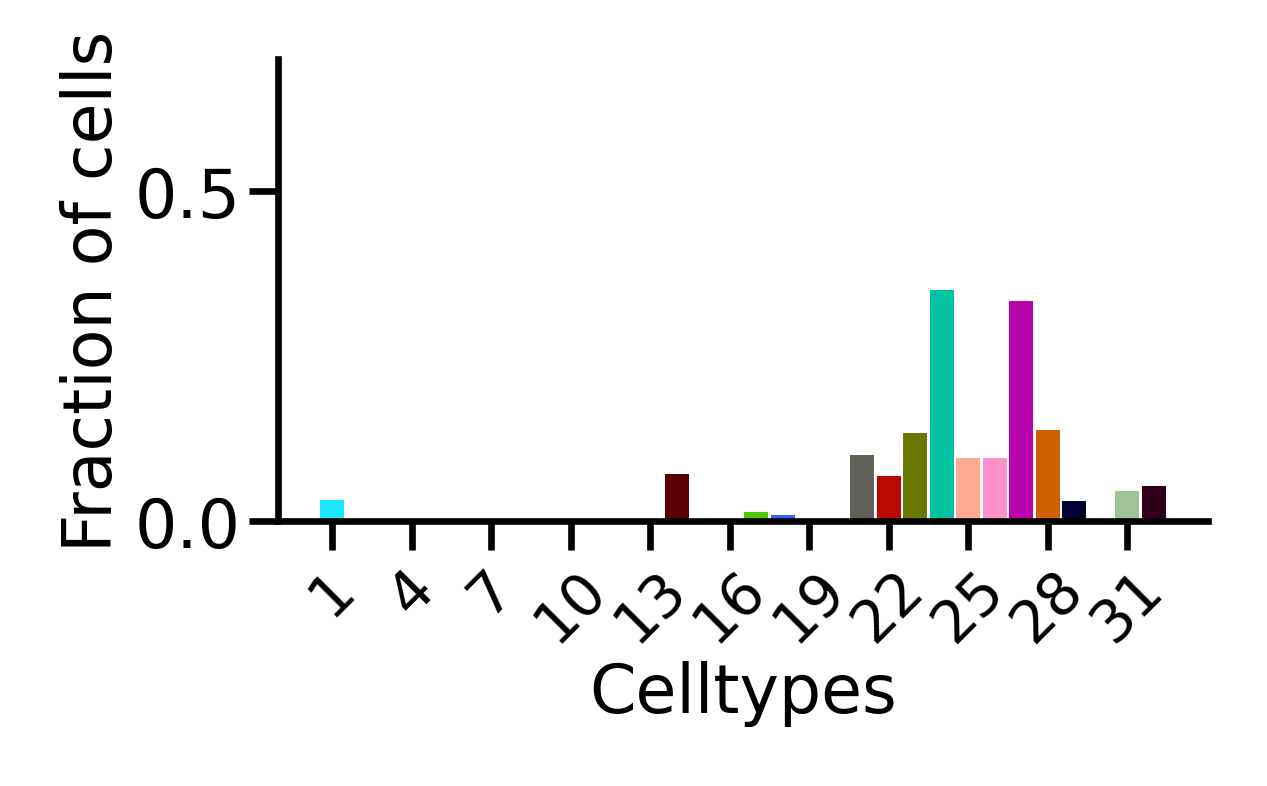

In [35]:
with mpl.rc_context(rc_dict_hist):
    fig = plt.figure()
    ax = plt.gca()
    for t in valid_types:
        perc = len(cleaned_df[(cleaned_df["celltype"]==t) & (cleaned_df["angle_freq"]>thr_angle_rad_freq)])/len(cleaned_df[cleaned_df["celltype"]==t])
        #print(t, perc)
        ax.bar(t, height=perc, width = .9,
               color=cmap_colors[t-1])
    sns.despine()
    ticklabels = [i for i in range(1, 32, 3)]
    ax.xaxis.set_major_locator(FixedLocator(ticklabels))
    ax.set_xticklabels(ticklabels, rotation=45, fontsize=7)
    #ax.set_xticks([])
    ax.set_xlabel("Celltypes")
    ax.set_ylabel("Fraction of cells")
    ax.set_ylim(0, 0.7)

### Temporal contrast

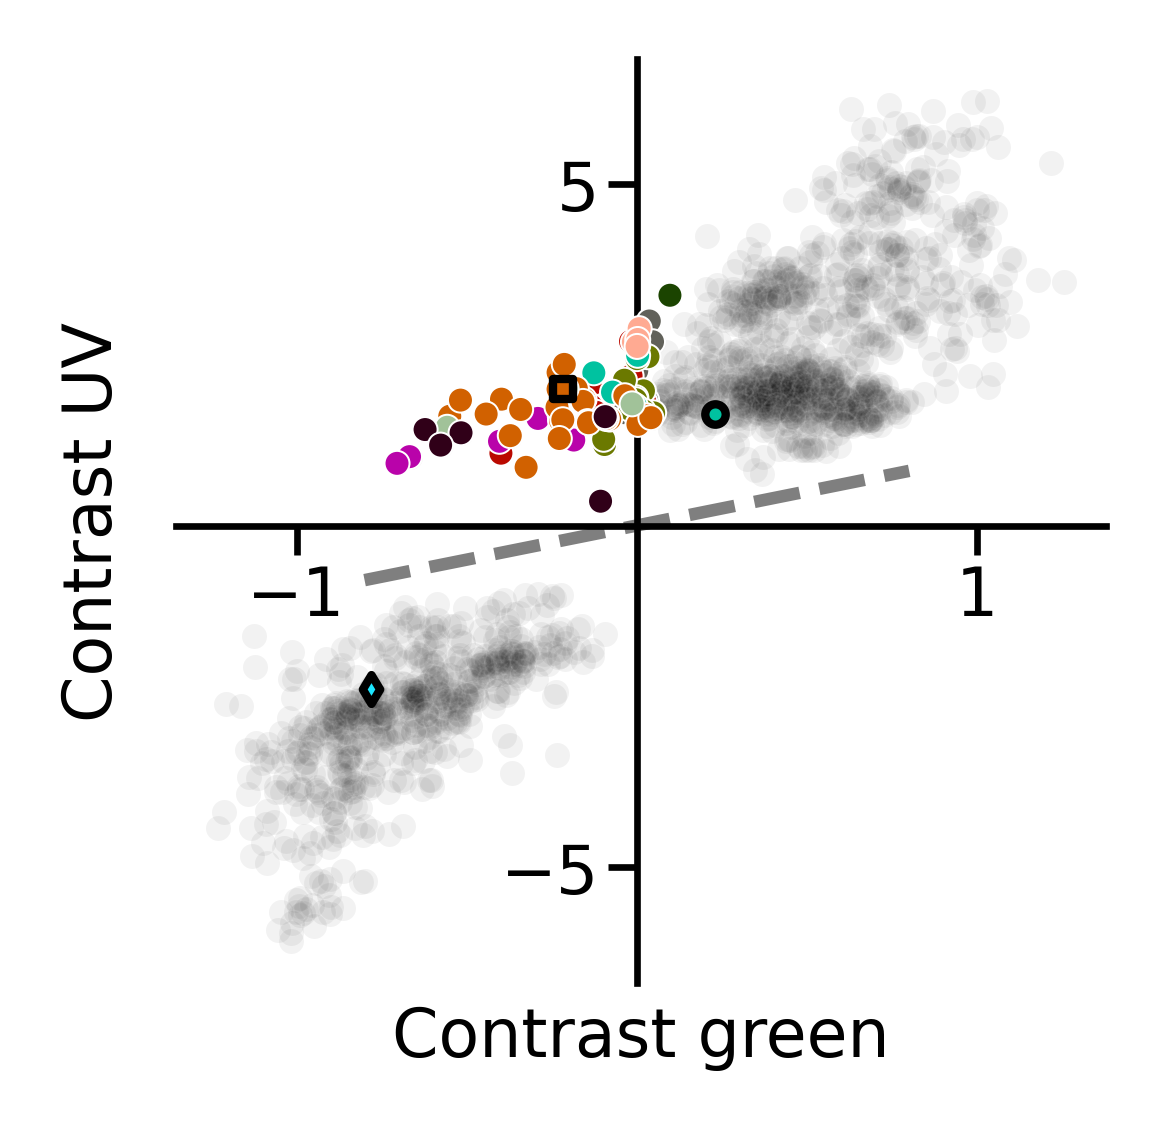

In [36]:
with mpl.rc_context(rc_dict):
    fig = plt.figure()
    xkey="center_temp_cont_green"
    ykey="center_temp_cont_uv"
    xlabel="contrast green"
    ylabel="contrast UV"
    g = sns.scatterplot(data=cleaned_df, 
                    x="center_temp_cont_green", 
                    y="center_temp_cont_uv",
                    color="k",
                        alpha=.05,
                        #hue="celltype", palette=palette, legend=False
                    )
    temp_types = np.unique(cleaned_df[cleaned_df["angle_temporal_contrast"]>thr_angle_rad]["celltype"])
    temp_palette = [cmap_colors[t-1] for t in temp_types]
    temp_df = cleaned_df[cleaned_df["angle_temporal_contrast"]>thr_angle_rad]
    sns.scatterplot(data=temp_df, 
                    x=xkey, 
                    y=ykey,
                    ax=g,
                    hue="celltype", palette=temp_palette, 
                    legend=False,
                    zorder=200,
                    
                    )
    for sample_id, m in zip(sample_ids, markers):
        plt.scatter(cleaned_df.loc[sample_id][xkey],
                         cleaned_df.loc[sample_id][ykey],
                   color = cmap_colors[cleaned_df["celltype"].loc[sample_id]-1], s=6, marker=m,
                    edgecolors='k',
                    zorder=200
                   )
    xlim = g.get_xlim()
    ylim  = g.get_ylim()

    g.xaxis.set_major_locator(FixedLocator([-1, 1]))
    g.yaxis.set_major_locator(FixedLocator([-5, 5]))
    
    g.plot([-.8, .8], [-.8, .8], color="k", linestyle="dashed",
           alpha=.5)

    g.set_xlabel("Contrast green",labelpad=45)
    g.set_ylabel("Contrast UV",labelpad=45)
    g.axes.spines["bottom"].set_position("zero")
    g.axes.spines["left"].set_position("zero")

    sns.despine()


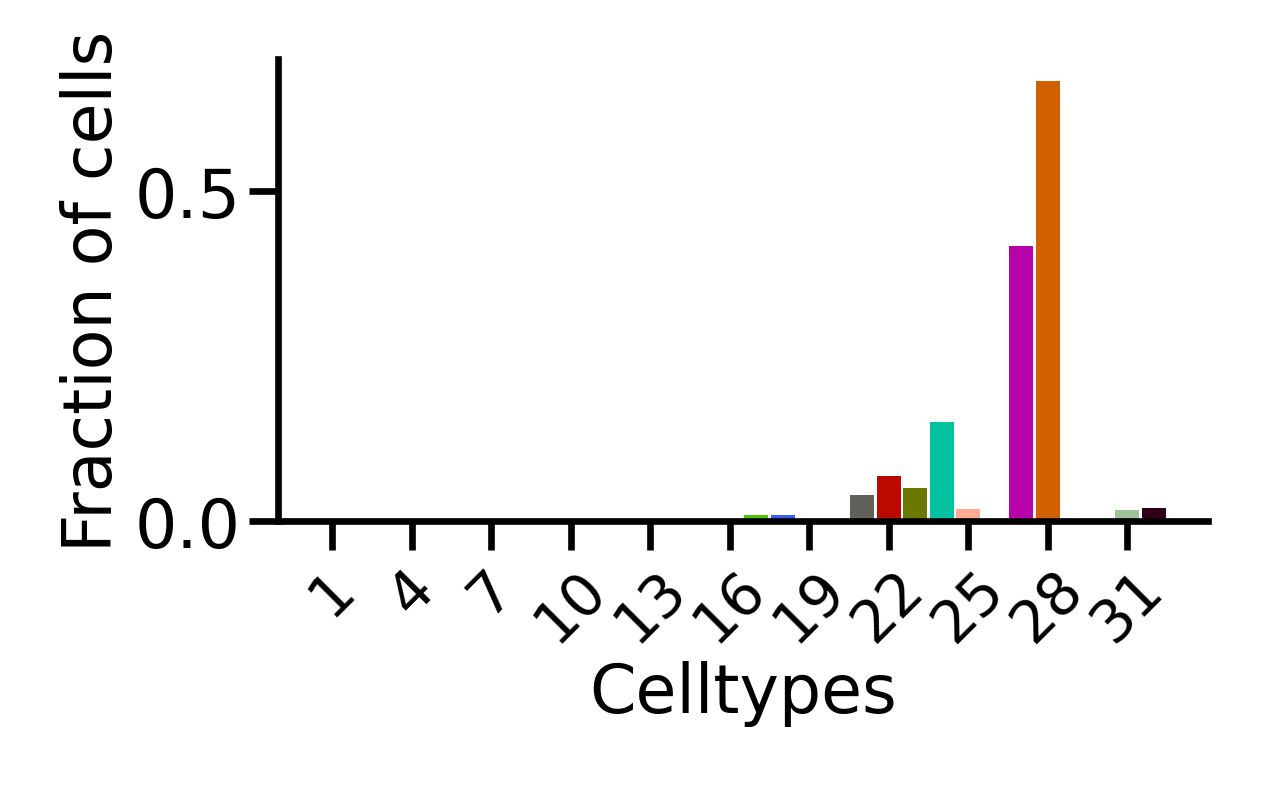

In [37]:
with mpl.rc_context(rc_dict_hist):
    fig = plt.figure()
    ax = plt.gca()
    for t in valid_types:
        perc = len(cleaned_df[(cleaned_df["celltype"]==t) & (cleaned_df["angle_temporal_contrast"]>.25*np.pi)])/len(cleaned_df[cleaned_df["celltype"]==t])
        #print(t, perc)
        ax.bar(t, height=perc, width = .9,
               color=cmap_colors[t-1])
    sns.despine()
    ticklabels = [i for i in range(1, 32, 3)]
    ax.xaxis.set_major_locator(FixedLocator(ticklabels))
    ax.set_xticklabels(ticklabels, rotation=45, fontsize=7)
    #ax.set_xticks([])
    ax.set_xlabel("Celltypes")
    ax.set_ylabel("Fraction of cells")
    ax.set_ylim(0, 0.7)